# MLiM 25440 Homework 4
### Brendan Sanderson

#### Imports and Mounting Drive

In [0]:
#General Useful Imports
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import kurtosis

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### SD2 and SD4 functions

In [0]:
# -*- coding: utf-8 -*-
 
"""
SD2
 
This module contains only one function, SD2, which performs spatial decorrelation of 2nd order.
"""
 
 
from __future__ import print_function
 
import numpy
from sys import stdout 
from numpy import argsort, cov, diag, dot, sqrt, absolute, arange
from numpy.linalg import inv, eig, eigh
from numpy import sqrt, ndarray, matrix, float64
 
#perform 2nd order spatial decorrelation
def SD2(data,m= None,verbose=True):
     
    """
    SD2 - Spatial Decorrelation of 2nd order of real signals 
     
    Parameters:
     
        data -- a 3n x T data matrix (number 3 is due to the x,y,z coordinates for each atom). May be a numpy array or
                matrix where 
                 
                n: size of the protein
                T: Number of snapshots of MD trajectory
     
        m -- dimensionality of the subspace we are interested in. Default value is None, in
        which case m=n.
         
        verbose -- print information on progress. Default is True.
     
    Returns:
     
        A 3n x m matrix U (NumPy matrix type), such that Y = U x data is a 2nd order
        spatially whitened source extracted from the 3n x T data matrix 'data'. If m is
        omitted, U is a square 3n x 3n matrix (as many sources as sensors). 
          
        Ds: has eigen values sorted by increasing variance
        PCs: holds the index for m most significant principal components by decreasing variance
        S = Ds[PCs] 
         
        S – Eigen values of the ‘data’ covariance matrix 
        B - Eigen vectors of the 'data' covariance matrix. The eigen vectors are orthogonal.
        """
     
    # GB: we do some checking of the input arguments and copy data to new
    # variables to avoid messing with the original input. We also require double
    # precision (float64) and a numpy matrix type for data.
     
    assert isinstance(data, ndarray),\
        "data (input data matrix) is of the wrong type (%s)" % type(data)
    origtype = data.dtype # remember to return matrix B of the same type
    data = matrix(data.astype(float64))    
     
    assert data.ndim == 2, "X has %d dimensions, should be 2" % data.ndim
    assert (verbose == True) or (verbose == False), \
        "verbose parameter should be either True or False"
     
    [T,n] = data.shape # GB: n is number of input signals, T is number of samples
     
    if m==None:
        m=n     # Number of sources defaults to # of sensors
    assert m<=n,\
        "SD2 -> Do not ask more sources (%d) than sensors (%d )here!!!" % (m,n)
 
    if verbose:
        print("2nd order Spatial Decorrelation -> Looking for %d sources" % m, file=stdout)
        print("2nd order Spatial Decorrelation -> Removing the mean value", file=stdout)
     
    data = data.T
     
    # remove the mean from data
    data -= data.mean(1)
     
    # whitening & projection onto signal subspace
    # ===========================================
    if verbose:
        print("2nd order Spatial Decorrelation -> Whitening the data", file=stdout)
    [D,U] = eigh((data * data.T) / float(T)) # An eigen basis for the sample covariance matrix
    k = D.argsort()
    Ds = D[k] # Sort by increasing variances
    PCs = arange(n-1, n-m-1, -1)    # The m most significant princip. comp. by decreasing variance
    S = Ds[PCs]
    # --- PCA  ----------------------------------------------------------
    B = U[:,k[PCs]].T    # % At this stage, B does the PCA on m components
  
    # --- Scaling  ------------------------------------------------------
    scales = sqrt(S) # The scales of the principal components .
    U = diag(1./scales) * B  # Now, B does PCA followed by a rescaling = sphering
    # --- Sphering ------------------------------------------------------
 
    Y = U * data # %% We have done the easy part: B1 is a whitening matrix and Y is white.
    return (Y, S, B.T, U)
 
    """
    NOTE: At this stage, Y is spatially whitened by performing PCA analysis on m components of the real data
    Y is now a matrix of spatially uncorrelated components.
    """

In [0]:
"""
TD4
 
This module contains only one function, TD4, which does joint diagonalization of cumulant matrices of order 4 which depends on the time delays. It allows us to extract signals which are as independent as possible and which was not obtained while performing SD2, TD2.
"""
 
from __future__ import print_function
 
import numpy as np
from sys import stdout 
from numpy import abs, append, arange, arctan2, argsort, array, concatenate, \
                  cos, diag, dot, eye, float32, float64, matrix, multiply, ndarray, newaxis, \
                  sign, sin, sqrt, zeros, ones
from numpy.linalg import eig, pinv
import numpy
import matplotlib.pyplot as plt
import warnings
 
def SD4(Z, m=None,U=None, verbose=True):
  
    """
    TD4 - Temporal Decorrelation of 4th order of real signals 
     
    Parameters:
     
        Z -- an m x T spatially uncorrelated of order 2 and temporally uncorrelated 
        of order 2 matrix (m subspaces, T samples). May be a  numpy array or a matrix where                  
                m: number of subspaces we are interested in
                T: Number of snapshots of MD trajectory
         
        V -- separating matrix obtained after doing the PCA analysis on m components
             of real data followed by temporal decorrelation of the spatially whitened 
             data
         
        lag -- lag time in the form of an integer denoting by time steps
         
        verbose -- print information on progress. Default is True.
     
    Returns:
     
       W -- separating matrix                 
        """
     
    # GB: we do some checking of the input arguments and copy data to new
    # variables to avoid messing with the original input. We also require double
    # precision (float64) and a numpy matrix type for X.
    lag = 0
    warnings.simplefilter("ignore", np.ComplexWarning)
    [n,T] = Z.shape # GB: n is number of input signals, T is number of samples
     
    if m==None:
        m=n     # Number of sources defaults to # of sensors
    assert m<=n,\
        "SD4 -> Do not ask more sources (%d) than sensors (%d )here!!!" % (m,n)
         
    print("4th order Spatial Decorrelation -> Estimating cumulant matrices")
     
    # Reshaping of the data, hoping to speed up things a little bit...
     
    Z = Z.T
    #Z = Z - Z.mean()
    dimsymm = int(((m) * (( m )+ 1)) / 2)   # Dim. of the space of real symm matrices
    nbcm = dimsymm  # number of cumulant matrices
    CM = matrix(zeros([(m),(m)*nbcm], dtype=float64)) # Storage for cumulant matrices
    R = matrix(eye((m), dtype=float64))
    Qij = matrix(zeros([m,m], dtype=float64)) # Temp for a cum. matrix
    Xim = zeros(m , dtype=float64) # Temp
    Xijm = zeros(m , dtype=float64) # Temp
    #Uns = numpy.ones([1,m], dtype=numpy.uint32)    # for convenience
    # GB: we don't translate that one because NumPy doesn't need Tony's rule
     
    # I am using a symmetry trick to save storage.  I should write a short note one of these
    # days explaining what is going on here.
    Range = arange(m) # will index the columns of CM where to store the cum. mats.
     
    # Removing 4th order temporal decorrelations with time delay = lag
    for im in range(m):
         
        Xim = Z[:,im]
        Xijm = multiply(Xim[0 : T - lag :] , Xim[lag : T : ])
              
        # Note to myself: the -R on next line can be removed: it does not affect
        # the joint diagonalization criterion
         
        Qij = dot(multiply(Xijm , Z[0: T-lag :]).T  , Z[lag : T :]) / float(T - lag)  - R - 2 * dot(R[:,im], R[:,im].T)
         
        # To ensure symmetricity of the covariance matrix a mathematical  computation is done
        Qij = (Qij + Qij.T)/2
        CM[:,Range] = Qij    
        Range = Range  + m 
        for jm in range(im):
                Xijm = multiply(Z[0 : T - lag :, im] , Z[lag : T  :, jm ])
                Qij = sqrt(2) * dot(multiply(Xijm, Z[0 :T - lag : ]).T , Z[lag : T :]) / float(T - lag) \
                    - R[:,im] * R[:,jm].T - R[:,jm] * R[:,im].T
                 
                # To ensure symmetricity of the covariance matrix a mathematical  computation is done
                Qij = (Qij + Qij.T)/2
                CM[:,Range] = Qij
                Range = Range + m 
     
     
    nbcm = int(nbcm)
    # Now we have nbcm = m(m+1)/2 cumulants matrices stored in a big m x m*nbcm array.
    H = matrix(eye(m, dtype=float64))
         
    Diag = zeros(m, dtype=float64)
    On = 0.0
    Range = arange(m)
    for im in range(nbcm):
        Diag = diag(CM[:,Range])
        On = On + (Diag*Diag).sum(axis=0)
        Range = Range + m
    Off = (multiply(CM,CM).sum(axis=0)).sum(axis=0) - On
     
    seuil = 1.0e-6 / (sqrt(T)) # % A statistically scaled threshold on `small" angles
    encore = True
    sweep = 0 # % sweep number
    updates = 0 # % Total number of rotations
    upds = 0 # % Number of rotations in a given s
    g = zeros([2,nbcm], dtype=float64)
    gg = zeros([2,2], dtype=float64)
    G = zeros([2,2], dtype=float64)
    c = 0
    s = 0
    ton = 0
    toff = 0
    theta = 0
    Gain = 0
     
    # Joint diagonalization proper
     
    if verbose:
        print("SD4 -> Contrast optimization by joint diagonalization", file=stdout)
     
    while encore:
        encore = False
        if verbose:
            print("SD4 -> Sweep #%3d" % sweep, end=' ', file=stdout)
        sweep = sweep + 1
        upds  = 0
        Hkeep = H
       
        for p in range(m-1):
            for q in range(p+1, m):
                 
                Ip = arange(p, m*nbcm, m)
                Iq = arange(q, m*nbcm, m)
                 
                # computation of Givens angle
                g = concatenate([CM[p,Ip] - CM[q,Iq], CM[p,Iq] + CM[q,Ip]])
                gg = dot(g, g.T)
                ton = gg[0,0] - gg[1,1] 
                toff = gg[0,1] + gg[1,0]
                theta = 0.5 * arctan2(toff, ton + sqrt(ton * ton + toff * toff))
                Gain = (sqrt(ton * ton + toff * toff) - ton) / 4.0
                 
                # Givens update
                if abs(theta) > seuil:
                    encore = True
                    upds = upds + 1
                    c = cos(theta) 
                    s = sin(theta)
                    G = matrix([[c, -s] , [s, c] ])
                    pair = array([p,q])
                    H[:,pair] = H[:,pair] * G
                    CM[pair,:] = G.T * CM[pair,:]
                    CM[:,concatenate([Ip,Iq])] = \
                        append( c*CM[:,Ip]+s*CM[:,Iq], -s*CM[:,Ip]+c*CM[:,Iq], \
                               axis=1)
                    On = On + Gain
                    Off = Off - Gain
                     
        if verbose:
            print("completed in %d rotations" % upds, file=stdout)
        updates = updates + upds
    if verbose:
        print("SD4 -> Total of %d Givens rotations" % updates, file=stdout)
     
    # A separating matrix
    # ===================
     
    W = H.T * U
     
    # Permute the rows of the separating matrix B to get the most energetic components first.
    # Here the **signals** are normalized to unit variance.  Therefore, the sort is
    # according to the norm of the columns of A = pinv(W)
 
    if verbose:
        print("SD4 -> Sorting the components", file=stdout)
     
    A = pinv(W)
    keys =  array(argsort(multiply(A,A).sum(axis=0)[0]))[0]
    W = W[keys,:]
    W = W[::-1,:]     # % Is this smart ?
     
     
    if verbose:
        print("SD4 -> Fixing the signs", file=stdout)
    b   = W[:,0]
    signs = array(sign(sign(b)+0.1).T)[0] # just a trick to deal with sign=0
    W = diag(signs) * W
    print(W.shape)
    return W
 
    """
     
    Main references:
    @article{Special Section on BSS: Independent Component Analysis and Signal Separation
      title     = "Robust Independent Component Analysis via Time-Delayed Cumulant Functions",
      author       = "Pando Georgiev and Andrzej Cichocki",
      HTML  = "http://search.ieice.org/bin/summary.php?id=e86-a_3_573",
      journal      = "IEE Proceedings-F",
      month = march, number = 3, pages = {573-580}, volume = E-86-A, year = 2003}
       
      Notes:
      ** Here we consider signals which are spatially and temporally decorrelated of 
      order 2
       
      1) Blind Source Separation problem of signals which are temporally correlated of 
      order 4 can be converted to a symmetric eigenvalue problem of generalized cumulant 
      matrix CM. The measure of independence corresponds to the 'diagonality' of a set of cumulant matrices. 
      Joint diagonalization of these cumulant matrices is done depending on time delay.
       
      2) We expect to use small number of significant eigenmatrices to efficiently 
      summarize all the 4th order information. 
       
      3) Since we are dealing with real signals, it becomes easy to exploit the 
      symmetries of the cumulants to further reduce the number of matrices to be 
      diagonalized.
       
      4) Computational errors can destroy the symmetricity of the cumulant matrices Qij and thus it's restored by performing
      Qij = 0.5*[Qij + Qij.T]
       
      5) The rows of the separating matrix Btd4 are resorted in such a way that the
      columns of the corresponding mixing matrix A=pinv(Btd4) are in decreasing order of (Euclidian)
      norm.  This is a simple, `almost canonical" way of fixing the indetermination of
      permutation.  It has the effect that the first rows of the recovered signals (ie the
      first rows of S = Btd4*data) correspond to the most energetic *components*.  Recall however that
      the source signals in S=Btd4 * data have unit variance.  Therefore, when we say that the
      observations are unmixed in order of decreasing energy, this energetic signature is to
      be found as the norm of the columns of A=pinv(Btd4) and not as the variances of the
      separated source signals.
       
      """

#### Loading and Preprocessing the data

In [0]:
cart_data = np.load('/content/drive/My Drive/MLiM-Datasets/HW4/data/Fs-peptide-cartesian-fit.npz')['arr_0']
dihed_data = np.load('/content/drive/My Drive/MLiM-Datasets/HW4/data/Fs-peptide-dihedral.npz') ['arr_0']
dihed_trans_data = np.load('/content/drive/My Drive/MLiM-Datasets/HW4/data/Fs-peptide-dihedral-transform.npz')['arr_0']
rmsd_data = np.load('/content/drive/My Drive/MLiM-Datasets/HW4/data/Fs-peptide-RMSD.npz')['arr_0']

## Question 1: Characterizing the statistical diversity of atomic fluctuations? [10 points]

In [0]:
#Calculate the mean for each row
cart_row_means = np.array([np.mean(c) for c in cart_data])
#Subtract the mean
cart_data_dev = np.array([c - cm for c,cm in zip(cart_data,cart_row_means)])

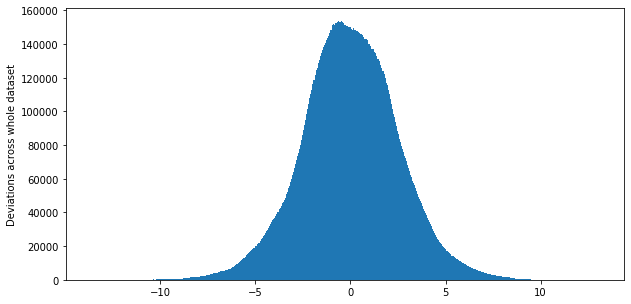

In [0]:
plt.figure(figsize=(10,5))
plt.ylabel("Deviations across whole dataset")
plt.hist(cart_data_dev.flatten(), bins=500)
plt.show()

In [0]:
#Calculate the standard deviation for each row
cart_row_sd = np.array([np.std(c) for c in cart_data])
#Calculate the kurtosis for each row
cart_row_k = np.array([kurtosis(c) for c in cart_data])

In [0]:
stats = []
for i in range(21):
  stat = [cart_row_means[i], cart_row_means[21 + i], cart_row_means[42 + i],
          cart_row_sd[i], cart_row_sd[21 + i], cart_row_sd[42 + i],
          cart_row_k[i], cart_row_k[21+ i], cart_row_k[42 + i]]
  stats.append(stat)
stats_df = pd.DataFrame(stats, index=["Atom " + str(i+1) for i in range(21)], columns=['X Mean', 'Y Mean', 'Z Mean','X SD', 'Y SD', 'Z SD','X Kurtosis', 'Y Kurtosis', 'Z Kurtosis'])
stats_df

,X Mean,Y Mean,Z Mean,X SD,Y SD,Z SD,X Kurtosis,Y Kurtosis,Z Kurtosis
Atom 1,-12.408318,-2.090805,0.295666,4.120913,2.532898,4.009609,-1.084495,-0.420826,-0.613641
Atom 2,-12.052340,-2.477648,-0.164607,3.382586,2.115206,3.301587,-1.071656,-0.676083,-0.863982
Atom 3,-11.419000,-2.452595,-1.275110,2.745841,1.889377,3.033773,-0.705598,-0.557577,-0.984426
Atom 4,-10.801811,-2.010226,-2.126549,2.362276,1.739161,2.608631,-0.017248,-0.812065,-0.538929
Atom 5,-9.736039,-1.910300,-2.644405,2.266386,1.904042,2.214582,-0.195236,-0.588442,-0.428439
Atom 6,-8.133619,-2.369828,-3.468885,2.143046,2.192854,2.422720,0.623223,0.029578,-0.343154
Atom 7,-6.912561,-1.259378,-4.460421,1.966392,2.353294,2.461136,2.690960,0.086549,0.194048
Atom 8,-5.872087,-0.513934,-3.745883,1.909488,2.251784,2.289526,2.584434,-0.168053,-0.314178
Atom 9,-4.486345,-1.174589,-3.434587,1.826931,1.891201,2.518376,1.381768,-0.412914,-0.444144
Atom 10,-2.691661,-0.695613,-4.119142,1.624600,1.673940,2.337234,0.304839,-0.244293,-0.671113


## Question 2: Finding regions of Fs-peptide that exhibit super-Gaussian characteristics [15 points]



*   **What would be the dimensions of the $\kappa$ values for the data that you have? [5 points]**

  The dimensions would be $3 \times N_a \times 1$ as each row has a $\kappa$ value and we compuate $\kappa$ for each direction of each atom or. $3N_a \times 1$ if I do not reshape the data.

*   **How many atoms in the data are super-Gaussian in all the three $(x, y, z) $ directions, and how many of them are sub-Gaussian in all the three directions $(x, y, z)$? [5 points]**

  2 atoms (atoms 7 and 15) are super-Guassian in all three directions as they have positive $\kappa$ values.

  8 atoms (atoms 1,2,3,4,5,18,19,21) are sub-Guassian in all 3 directions as they have negative $\kappa$ values in all 3 directions.
   
*   **Do you find any atoms that have purely Gaussian behaviors? What proportion of the data exhibits higher order statistics? [5 points]**

  None of the atoms have purely Gaussian behaviors as none of them exhibit a $\kappa$ value that is exactly 0. Thus all of the dataexhibits higher order stastistics.





## Question 3: What to do with dihedral coordinates? [15 points]

**The dihedral coordinates represent a new challenge; how would you characterize the statistical nature of
these deviations? For an idea, let’s first think of a way in which you can examine the values. Find the (min,
max) of the dihedral array: Fs-peptide-dihedral.npz. You should do a spot check to see if thevalues are distributed between -π and +π (-180 and +180 degrees)**

In [0]:
#Spot check
mini = min(dihed_data.flatten())
maxi = max(dihed_data.flatten())
print("The minimum is:", mini)
print("The maximum is:", maxi)

The minimum is: -3.1415906
The maximum is: 3.1415925


It is clear that the maximum and the minimum are about $\pi$ and $-\pi$ respectively.

**This requires you to think a bit harder about working with circularly distributed data. Can you come up with suggestions on how we can convert the data into an array where the data is not distributed between ±π, but rather, you can use the same functions (that you used in the previous question) to calculate (μ, σ, κ)? Note that there are no right answers/ wrong answers here; just come up with a reasonable suggestion for how you’d overcome this problem with circular statistics. [5 points]**

One possible way we could transform the data is to calculate an $x$ and $y$ value for each angle by calculating the sin and cos of each angle. This idea is based off how you can convert polar coordinates to cartesian coordinates. We can set $x = cos(\theta)$ and $y = sin(\theta)$. As there are two angles, we can just calculate an $x$ and $y$ value for each of the two angles. Giving us $x_1 = sin(\psi), y_1 = cos(\psi), x_2 = cos(\phi)$ and $y_2 = sin(\phi)$ for each set of dihedral angles. This guys us values in the standard coordinate plane, which we can then use to calculate the standard second order statistics.

In [0]:
#Calculate the mean for each row
dihed_row_means = np.array([np.mean(r) for r in dihed_trans_data])
#Calculate the standard deviation for each row
dihed_row_sd = np.array([np.std(r) for r in dihed_trans_data])
#Calculate the kurtosis for each row
dihed_row_k = np.array([kurtosis(r) for r in dihed_trans_data])

In [0]:
stats = []
for i in range(21):
  stat = [np.mean(dihed_row_means[4*i:4*i+4]), np.mean(dihed_row_sd[4*i:4*i+4]), np.mean(dihed_row_k[4*i:4*i+4])]
  stats.append(stat)
stats_df = pd.DataFrame(stats, index=["Atom " + str(i+1) for i in range(21)], columns=['Mean', 'SD', 'Kurtosis'])
stats_df

,Mean,SD,Kurtosis
Atom 1,-0.087045,0.479912,5.877372
Atom 2,-0.074855,0.455847,5.854973
Atom 3,-0.115890,0.445174,7.333082
Atom 4,-0.102866,0.450949,5.790777
Atom 5,-0.126005,0.480249,7.404467
Atom 6,0.000000,0.000000,-3.000000
Atom 7,-0.064220,0.349907,9.551263
Atom 8,-0.079106,0.408509,6.812235
Atom 9,-0.074272,0.430457,4.432206
Atom 10,-0.124524,0.457997,7.605571


Above are the μ, σ, κ values for each atom. I calculated μ, σ, κ for each of the 4 values and then I took the mean of the 4 values for each atom and reported the mean. This was recommended on campus wire.

On campus wire, it was stated to calculated the average for each $\kappa$ value, so above I have done this.

*   **What would be the dimensions of the κ values for the data that you have? [2 points]**

  The dimensions of the $\kappa$ values are $21 \times 1$ as I take the average of the $\kappa$ values for the 4 different transformed values for each atom. I did this as it was recommended on campus wire.

*   **How many dihedral angles in the data are super-Gaussian, and how many of them are sub-Gaussian? [4 points]**

  21 atoms (1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20 and 21) are super-Guassian as they have $\kappa$ values that are larger than 0. 1 atom (atom 6) is sub-Guassian as it exhibits a $\kappa$ value less than 0.

*   **Do you find any dihedrals that have purely Gaussian behaviors? What proportion of the data exhibits higher order statistics? [4 points]**

  As in the case of cartesian coordinates, no atoms are purely Guassian has no atoms have a $\kappa$ value that is exactly 0. Thus, all of the data exhibits higher order statstics.


## Question 4: Using second-order statistics to characterize atomic fluctuations [30 points]

Below I define `calc_sd2`, which calcluates the sd2 values and `plot_sd` which plots the cumlative variance plot as well as the 3rd projection plot. I reuse the plot function in question 5. Note that the graph displayed is fairly large and you may have to scroll to see the cumlative variance plot.

In [0]:
def calc_sd2(X):
  # perform SD2
  Y,S,B,U = SD2(X.T,m=X.shape[0], verbose=False)

  # obtain cumulative variances
  [pcas,pcab] = np.linalg.eig(np.cov(X))
  si = np.argsort(-pcas.ravel())
  pcaTmp = pcas
  cumvar = np.cumsum(pcaTmp.ravel()/np.sum(pcaTmp.ravel())) * 100

  # a 3D plot of the projections obtained from SD2 modes
  return Y, U, cumvar

def plot_sd(Y, RMSD, cv = None):
  Y_sd = np.asarray(Y)
  fig = plt.figure(figsize=(30,20))
  gs = fig.add_gridspec(ncols=3, nrows=3, height_ratios=[2,1,2])
  ax3D = plt.subplot(gs[0:2,0:2], projection='3d')
  p3d = ax3D.scatter(Y_sd[0,::], Y_sd[1,::], Y_sd[2,::], s=10, c=RMSD,
  marker='o')

  ax3D.set_xlabel(r'$\bf{SD2_1}$');
  ax3D.set_ylabel(r'$\bf{SD2_2}$');
  ax3D.set_zlabel(r'$\bf{SD2_3}$');
  cbar = fig.colorbar(p3d, ax=ax3D)

  for i in range(3):
    ax3Di = plt.subplot(gs[2,i], projection='3d')
    p3di = ax3Di.scatter(Y_sd[0,::], Y_sd[1,::], Y_sd[2,::], s=10, c=RMSD, marker='o')
    ax3Di.set_xlabel(r'$\bf{SD2_1}$');
    ax3Di.set_ylabel(r'$\bf{SD2_2}$');
    ax3Di.set_zlabel(r'$\bf{SD2_3}$');
    fig.colorbar(p3di, ax=ax3Di)
    ax3Di.view_init(30, 90*(i+1))

  if cv is not None:
    axCV =  plt.subplot(gs[0,2])
    axCV.plot([0] + list(cv))
    axCV.set_title("Total Variance Covered by Number of Components")
    axCV.set_ylabel("Cumulative Variance Covered")
    axCV.set_xlabel("Number of Components")

In [0]:
Yc, Uc, cv_c = calc_sd2(cart_data)
Yd, Ud, cv_d = calc_sd2(dihed_trans_data)

#### (i) Cartesian Coordiante Graphs

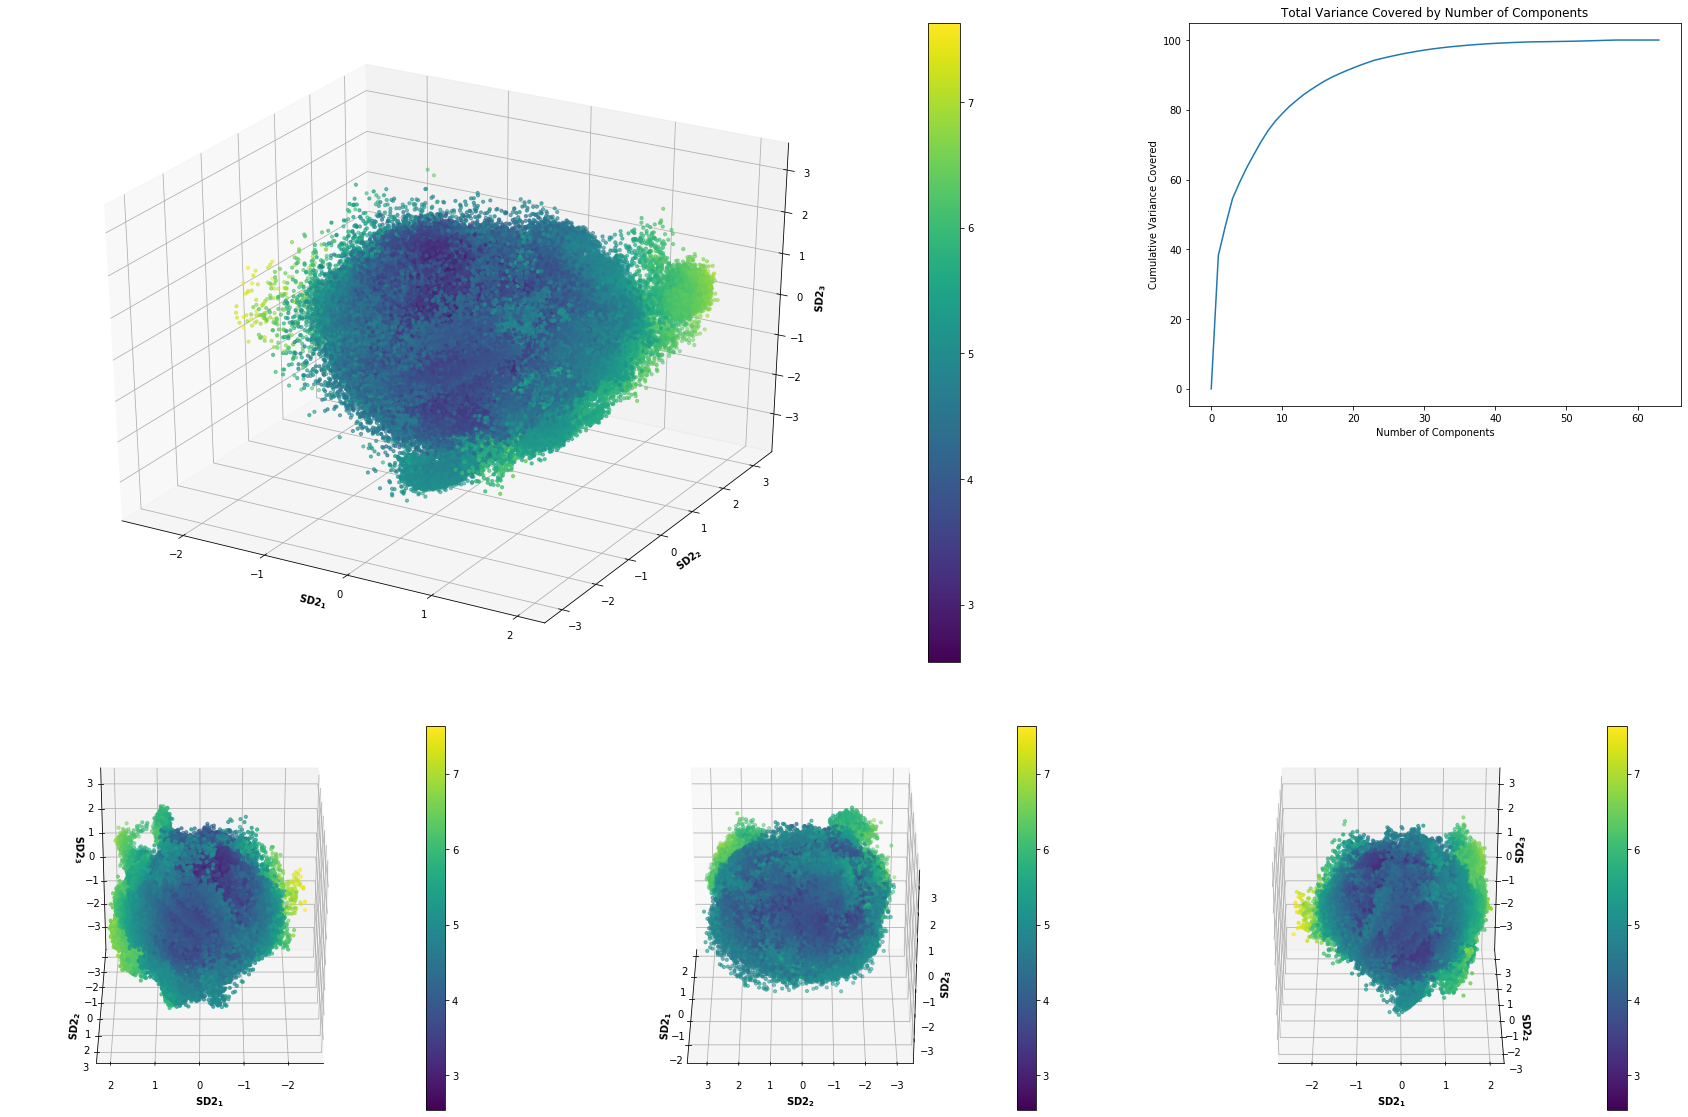

In [0]:
plot_sd(Yc, rmsd_data, cv_c)

#### (ii) Dihedral Coordinate Graphs

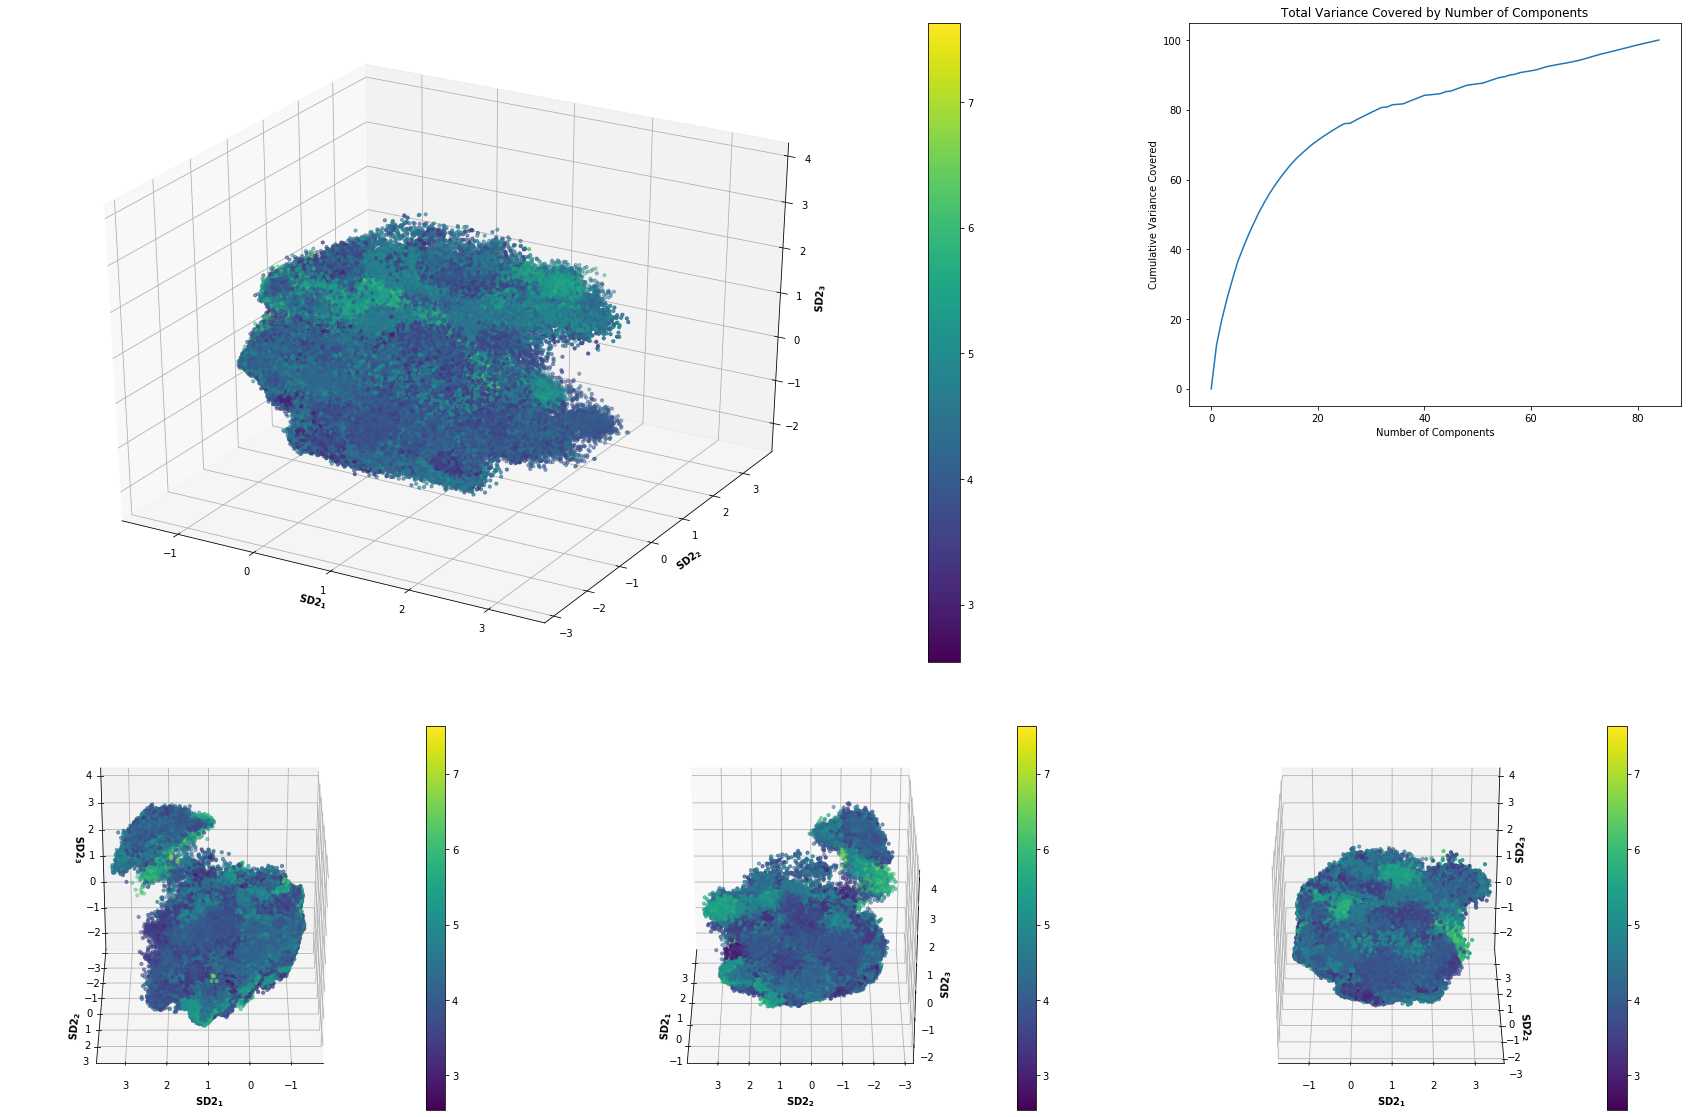

In [0]:
plot_sd(Yd, rmsd_data, cv_d)

#### (iii) Question Responses

*   **In order to generate a scree plot, plot the variable cumvar. What can you infer from the cumulative variance plot? [5 points]**

  The function `sd2_plot` generates the cumulative variane plot and projects the data onto the eigenvalues. Above you can see the cumulative variance graphs for both the cartesian coordinates and dihedral coordinates. From these graphs, we can see how much of the variance in the data can be accounted for by using a certain number of components.

  From the cartesian plot, you can see that about 10 components account for about 80% of the variance in the graphs and 30 components account for almost all of the variance. This is significant as a lot of the variance and movement in the cordinate plane is uniform as few components can explain a lot of the variance, which in turn means that the atoms in the protein are moving together in a similar fashion as the protein folds. However, there is still definitely some randomness and uncoordination in the movements as 30 components is almost half of the dimension in the data.

  From the dihedral plot, around 20 components or just under half of them account for 80% of the variance. This is not as significant as for the cartesian plot, which is evidence of the fact that as a protein folds, the angles change more independently than the position of the atoms. There is definitely still a significant amount of uniform movement as 80% in 1/3 of the total dimension is still a high number.


*   **Based on the scatter plot p3d what can you gather from the arrangement of the 3D projections of the modes and can you comment if that is sufficient to characterize the conformational landscape of the MD simulated molecular data? [15 points]**

  Cartesian:
  The cartesian plot shows how the principal components of the atoms vary over time. It has a large centered cluster with a lower RMSD. This makes sense as there is the area that represents where the atoms are in their mean location. As most of the atoms are not sub-Guassian, the atoms will spend a lot of frames locations around the mean and thus it makes sense that the principal components have a centered cluster. The cluster is wider in the $SD2_1$ and $SD2_2$ directions, which makes sense as these components represent more of the variance in the data. It appears that there are a partial few rings around this main cluster with higher RMSD values. These partial rings could be interpreted as paths of motion of atoms as the protein folds over itself. The fact that the rings have a definitive shape is evidence that the motion of the atoms is uniform as the proteins foldover itself together. However, the pressence of multiple rings makes the movement seem to be somewhat random as the rings exhibit variation in different paths and directions.

  Dihedral: The scatter plot for the dihedral angles shows how the principal components of the angles vary over time. It also has a centered dense cluster. This also represents that the angles spend a lot of time close to the angle means. However, this center cluster seems to be large as it contains points with a decently high RMSD and is more spread out. There seems to be a few smaller subclusters outside of the main cluster with medium RMSD values. There also appears large dominent secondary cluster that has the highest RMSD values in the second and third components with higher RMSD values. This means that the movement away from the mean has the same general motion as RMSD deviations are clustered into the same general area. However, this cluster is fairly large, which means that the movement of the angles may be somewhat uniform, but there is definite random variation in this movement as the cluster is fairly large.

*   **After implementing the entire workflow for cartesian coordinates and the transformed dihedral coordinates, now you will have two sets of results. Based on this, please compare and contrast the outcome of your analysis in both coordinate spaces. You may use the help of generated plots in order to compare the two results (cumulative variance plot and 3D scatter plot of projections). [5 points]**

  In terms of the cumlative variance plot, it is clear that the cartesian coordinates are more similar in terms of the principal components of the data. 10 coordinates cover 80% of the variance for cartesian coordinates, but only 60% for dehedral coordinates. This is significant as it signifies that the variance is more uniform for the cartesian coordinates opposed that that of the dihedral coordinates. This means that the atoms move more in unison more than the angles do, which makes sense when you think about the fact that the protein is folding in what should be an efficient manner. This also makes sense as the atoms are bound together and thus can really only move together while the angles are free to extend and contract independently.

  In terms of 3d projection plot, it is clear that both graphs have a large portion of the data centered around the mean. The center cluster is clearly more spread out in the case of the dihedral angles and there are far more outliers outside of the cluster. There is also a difference in the values that hold a higher RMSD. The variation in the cartesian plot appears to form rings that represent paths of movement of the atoms and in the dihedral plot, there appears to be secondary clusters that represents for the variation from the mean in the angles, including 1 prominent secondary cluster. Both seem to exhibit a sort of a uniform periodic deviation from the mean that is somewhat random, but there is far more randomness in the dihedral case, displaying that the atoms move in a more uniform motion than the angles do.

*    **List some of the drawbacks of PCA on this dataset. [Hint: refer to the histogram of deviations plot]. [5 points]**

  Looking at the results from questions 1-3, it is clear that the data is sub-Guassian. This means that the deviations in the data are far more common as the data exhibits a more uniform distribution than that of a normal one. This makes the PCA results slightly more difficult to interpret as they do not represent the different variations. From the above graph, it is evident that the results are extremely dense, which makes it difficult to pick apart and seperate the data in order to interpret it. In addition, in the instance above 3 linear vectors are used to represent all of the data and it may be useful to try to generalize the difference in the variation or anharmonic motion in the data through ICA instead of generalization the commonality in the variation or harmonic movement data. Also, there is no apparent energetic honogeneity and there is no knowledge about intrinsic dependencies in PCA, which is a drawback as discussed in class.

## Question 5: Going beyond second-order statistics to characterize atomic fluctuations [30 points]

Below I define `calc_sd4`, which calulates the sd4 values. I chose $m = 20$ for the cartesian coordiantes and $m = 25$ for the dihedral coordinates.

In [0]:
def calc_sd4(X, Y, U, m = 20):
  # perform SD4
  W = SD4(Y[0:m,:], m=m, U=U[0:m,:], verbose=False)
  # obtain data projections on SD4 modes

  Z = W.dot(X)
  return Z

In [0]:
Zc = calc_sd4(cart_data, Yc, Uc)
Zd = calc_sd4(dihed_trans_data, Yd, Ud, m = 25)

4th order Spatial Decorrelation -> Estimating cumulant matrices
(20, 63)
4th order Spatial Decorrelation -> Estimating cumulant matrices
(25, 84)


#### (i) Cartesian Coordinates

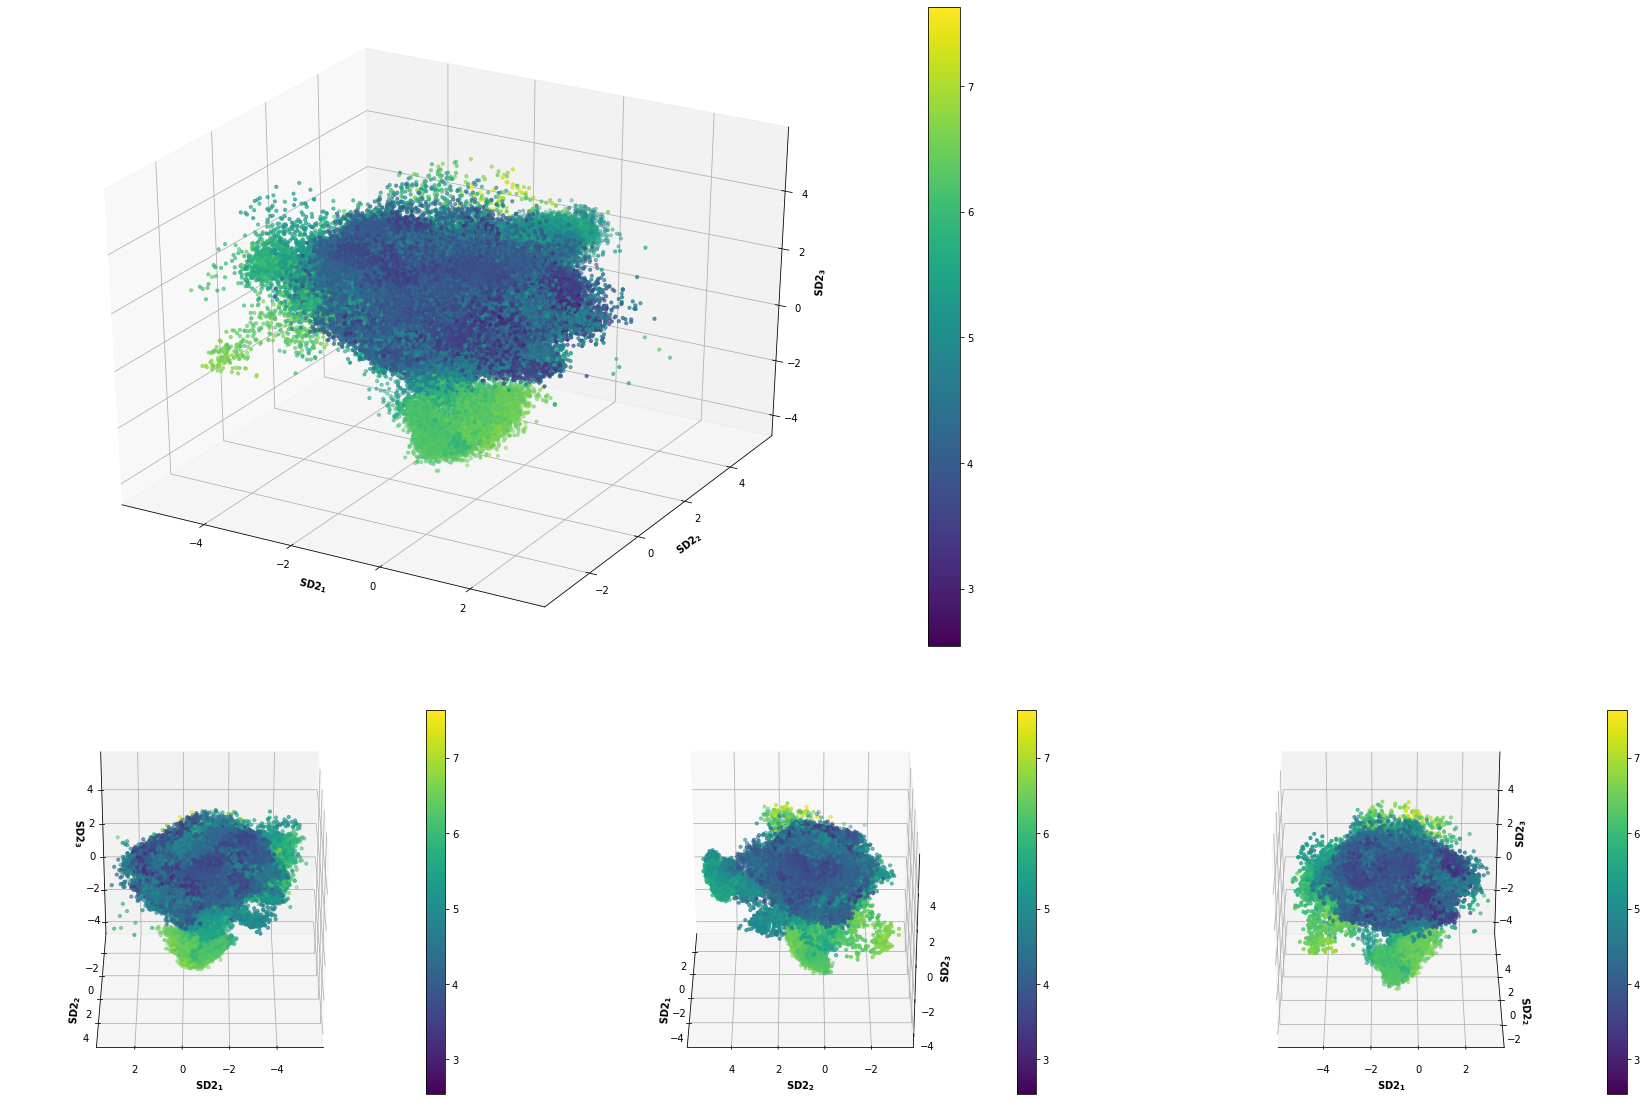

In [0]:
plot_sd(Zc, rmsd_data)

#### (ii) Dehedral Coordinates

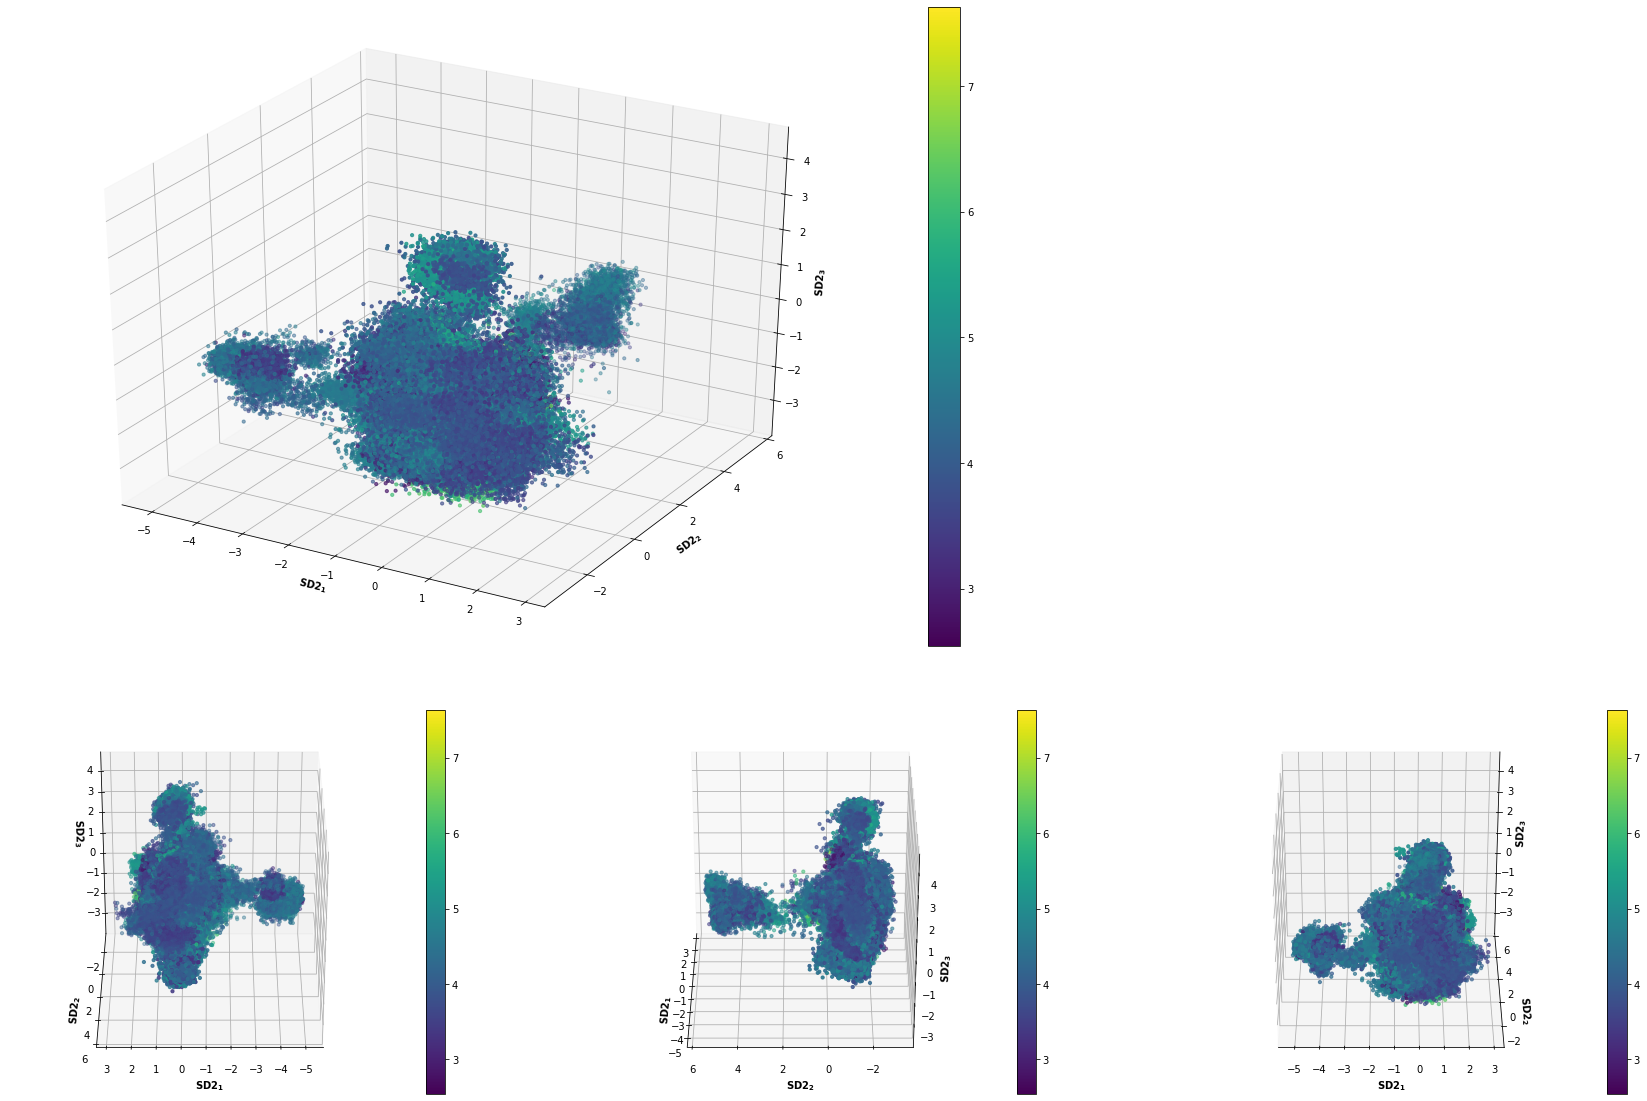

In [0]:
plot_sd(Zd, rmsd_data)

#### (iii) Question Responses


*   **After generating the scatter plot p3d based on SD4 modes of motion, what can you gather from the spatial arrangement of the 3D projections? Please provide an explanation based on your visual interpretation of the plot. Next, relate your visual interpretation of the scatter plot to the collective behavior of residues in Fs-peptide. [5 points]**

  Cartesian:
  The 3d projection of the ICA represents the non-orthogonal behavior of the atoms in the fs-peptide. The Cartesian graph has the same central cluster as displayed in question 4, but the variation from is far different. There appears to be about 3 subclusters that hold the higher RMSD values. This indicates that there is definitely a main state or position that the protein is in, but there are also several different states or composition of positions that are distinction different from the main form of the protein which the protein spends a significant amount of time in. Perhaps, the different clusters represent the main different stages of the shape of the protein through its folding process.

  Dihedral:
  The dihedral plot interesting has a similar form to that of the Cartesian plot. It has a main central cluster as well as about 3 apparent smaller clusters. Perhaps, these 3 subclusters also represent 3 different states or shapes that the proteins find themselves in during the folding process. We may be given similar shapes in our 3d projection graphs as each subcluster in the cartesian state relates to a subcluster in the dihedral state. The clusters in the dihedral plots almost seem more defined, yet unrelated to the RMSD values.

*   **Please compare the two 3D scatter plots generated in Q4. and Q5. Can you provide a reasonable explanation behind the differences in the spatial arrangement of conformations projected in three dimensional space in both the scatter plots. Next, can you analyze and explain how did the usage of fourth-order statistics help in dealing with the shortcomings of second-order statistics? [10 points]**

  Cartesian:
  The main difference in the cartesian coordinates between q4 and q5 is that in q4, the variation appears to take the shape of rings around the central cluster, where as in q5 the variation takes the shape of sub clusters independent of the main cluster. I predict that this is because the second order statistics give us components that represent common motions of the atoms, which are represented by the rings. The forth order statistics give us common distinct states that are represented by the clusters. Second order statistics are not powerful enough to distinctly seperate such states and can only be used to summate general trends in the data instead of seperating the data into different categories.

  Dihedral:
  The main difference in the dihedral angles is that in q4, the secondary clusters were very spread out and not representitive of much except for the fact that there was more variation in the dihedral case. In q5, we are given similar clusters to that of the cartesian coordinates, which again represents the forth order statistics ability to seperate the data into distinct clusters or groups that represent the main different states of the protein.

*   **Once again you will be having two sets of results after implementing SD4 on cartesian coordinates and transformed dihedral coordinates. Please compare the two results from SD4 module like you did for SD2 in Q4. What are you learnng from SD4? [10 points]**

  The two sets of results are extremely similar as stated above, they both have a main central cluster with about 3 subclusters that are similar in shape. This is awesome as it leads to be believe that the subclusters in each graph are related and combined they represent a distinct set of positions and angles that the peptide takes. The positions and angles can be combined to represent a distinct shape of the peptide. These shapes can be the main different phases of shape that the peptide goes through throughout its folding process. This is really cool as the second order statistics were not able to make such a seperation.

*   **In this assignment we only looked at the fluctuations of atoms at a spatial scale (in second-order by doing SD2 and fourth-order by performing SD4). Do you think it is necessary to think in terms of other scales? If so, what would be an ideal approach to address this? [5 points]**

  It definitely could be helpful to look at other scales. We can learn a lot from the spatial scale, but beyond looking at trends of shape and motion, it does not help to depict much else. We are attempting to understand the functions of a protein through the folding process, but there is a lot of other features that can help to determine this. For instance, we could look at other statistics like energy contained within each bond, the charge of different atoms and/or any other bonds formed between atoms. These are things can can be measured through molecular dynamic simulation, so we could simply record the values of each of these for each frame in addition to for each atom.




## Write Up

From question 1, we see that the overall distribution of the variations in the data. It is clear that the data is sub-Gaussian as there is a sort of hump about the mean, but the tails fall off fairly quickly. Thus, there is a lot of small variance about the mean, but very little extreme variance about the mean. This is backed up by our answers in questions 2 and 3 as we see that we have more sub-Gaussian atoms that super-Gaussian. The atoms that are sub-Gaussian are the atoms on the ends of the protein. This is interesting as these atoms are the ones that likely have the most irregular motion as the effect of the protein folding as the greatest impact on these atoms. Thus, there is going to be a far more common smaller variation, which makes the distribution of the movement of the atom far more uniform. In the case of cartesian coordinates, there are far less sub-Gaussian atoms than in the dihedral case (8 versus 20). This means that the movement of the atoms is far more normal than the angles between them. This makes sense as when a protein folds, we expect far more irregular movement in the angles between the atoms while the atoms try to stay as constant a location as possible to make the protein folding energy efficient.

In question 4, we see there is far more irregular variation in the angles, which backs up the response that was given above. This is represented in the cumulative variance plots as the same number of components covers less variance in the dihedral case than in the Cartesian case. This 
is also represented in the 3d projection plots as the center cluster is larger in the case of the Cartesian coordinates. Also, we see that the variation in the cartesian coordinates appears to have a spiraling motion, which represents how the protein rotates as it folds over itself. The dihedral angles appear to have secondary clusters, including 1 large secondary cluster, which shows that the deviation is less uniform than the deviation in the coordinates. The center cluster is also far more spread out in the case of the dihedral coordinates, which is also an indication that there is more variation in the angles.

In question 5, we are able to separate the positions of the protein into distinct shapes. This is extremely interesting to me as these states could be representative of the main forms that the protein takes as it folds. This truly shows the power of the fourth order statistic as they are able to separate the data into unique groups whereas the second order statistics can only generalize trends. I have never looked at fourth order statistics before, but the fourth order statistics clearly have expressive power that is extremely valuable and unique.
